# Attempt to Compare ProtoPNet with InterpretableTest class wrapper (13 Test Samples Used)
### ResNet50 backbone is used for both
### Same dataset consisting of combination of figshare, SARTAJ, and BR35H datasets

In [1]:
# train the ProtoPNet model
#!python /home/alan/Documents/YOLOV8_interpretable/ProtoPNet/main.py

#### Highest test Accuracy: Epoch 20 - 0.9245
#### Now that a model has been obtained, we will perform inference on the test set and retreive the nearest training samples that contain the patches closest to the prototypes used for each classification in the test set

In [2]:
# modified local_analysis.py to iterate through a directory instead of single image
import os
import torch
import numpy as np
from PIL import Image
from torch.autograd import Variable
import torchvision.transforms as transforms
from helpers import makedir, find_high_activation_crop
from preprocess import mean, std, preprocess_input_function, undo_preprocess_input_function


class Args:
    gpuid = ['0']  
    modeldir = '/home/alan/Documents/YOLOV8_interpretable/ProtoPNet/'  
    model = '20nopush0.9245.pth' 
    imgdir = ['/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images'] 


args = Args()


# Preprocessing function
def preprocess(img):
    # Convert grayscale images to RGB
    if img.mode != 'RGB':
        img = img.convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    return transform(img)

# Load the model
load_model_path = os.path.join(args.modeldir, args.model)
ppnet = torch.load(load_model_path)
ppnet = ppnet.cuda()
ppnet_multi = torch.nn.DataParallel(ppnet)

# Define the test set directory
test_set_dir = args.imgdir[0]
save_dir = '/home/alan/Documents/YOLOV8_interpretable/ProtoPNet/local_analysis_results_Test_1'  # Specify the directory where you want to save the results
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

counter=0
results = []

# Iterate through the test set
for img_name in os.listdir(test_set_dir):
    if not img_name.endswith(('.png', '.jpg', '.jpeg')):
        continue
    counter += 1
    # Process every 100th image of test set
    if counter % 100 != 0:
        continue

    test_image_path = os.path.join(test_set_dir, img_name)
    print(test_image_path)
    img_pil = Image.open(test_image_path)
    img_tensor = preprocess(img_pil)
    img_variable = Variable(img_tensor.unsqueeze(0)).cuda()

    # Perform inference
    logits, min_distances = ppnet_multi(img_variable)
    conv_output, distances = ppnet.push_forward(img_variable)
    prototype_activations = ppnet.distance_2_similarity(min_distances)
    prototype_activation_patterns = ppnet.distance_2_similarity(distances)

    # Get the most activated prototypes
    array_act, sorted_indices_act = torch.sort(prototype_activations[0])
    top_prototypes = sorted_indices_act[-10:].cpu().numpy()

    # Save the results for this test image
    results.append({
        'test_image': test_image_path,
        'prototypes': top_prototypes
    })


    # Log or save the prototypes and activations as needed (same as the original script)

# Save the results array for further analysis
np.save(os.path.join(save_dir, 'test_set_prototype_results.npy'), results)


/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y501.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y906.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y645.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y755.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y922.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y772.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y363.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y307.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y53.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y117.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y73.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y915.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y1184.jpg


In [3]:
from scipy.stats import pearsonr
import os
import torch
import numpy as np
from PIL import Image

def calculate_pearson_correlation(interpretable_results, protopnet_results):
    n = len(interpretable_results)  # number of test samples
    assert n == len(protopnet_results), "The number of test samples should be the same in both results."

    k = len(interpretable_results[0])  # number of nearest neighbors/patches
    assert k == len(protopnet_results[0]), "The number of nearest neighbors/patches should be the same in both results."

    correlations = []

    for i in range(n):
        for j in range(k):
            interpret_features = interpretable_results[i][j]
            proto_features = protopnet_results[i][j]

            # Ensure proto_features have the same length as interpret_features by padding
            if len(proto_features) < len(interpret_features):
                proto_features = np.pad(proto_features, (0, len(interpret_features) - len(proto_features)), 'constant')

            # Calculate Pearson correlation
            corr, _ = pearsonr(interpret_features, proto_features)
            correlations.append(corr)

    # Convert correlations list to a numpy array and reshape to (n, k)
    correlations_array = np.array(correlations).reshape(n, k)

    return correlations_array

def transform_patch_results_to_array(patch_results, cnn_interpreter):
    n = len(patch_results)  # Number of test samples
    k = len(patch_results[0]['patches'])  # Number of prototypes
    
    # Initialize the list to store extracted features
    extracted_features = []
    cnn_interpreter.training = False
    for result in patch_results:
        for patch in result['patches']:
            # Extract features from the original training image corresponding to the patch
            image_id = patch['image_id']
            cnn_interpreter.reset_features()
            features = feature_extraction_function(image_id, cnn_interpreter)
            extracted_features.append(features)
    
    # Convert the list to a numpy array and reshape it to (n, k, m)
    results_array = np.array(extracted_features).reshape(n, k, -1)

    return results_array

def feature_extraction_function(image_path, cnn_interpreter):
    # Load the image
    img_pil = Image.open(image_path)
    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img_tensor = preprocess(img_pil).unsqueeze(0)  # Add batch dimension
    # Pass the image through the model
    img_variable = torch.autograd.Variable(img_tensor).cuda()
    with torch.no_grad():
        cnn_interpreter.model(img_variable)
    # Extract features from the target layer
    features = cnn_interpreter.inference_features
    features = torch.tensor(features).cpu().numpy().squeeze()
    return features

In [5]:
# modified global_analysis.py to work with modified local_analysis.py and store image ids that patches originate from

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from helpers import makedir
from settings import train_push_dir, test_dir
import find_nearest
from preprocess import preprocess_input_function





def find_nearest_patches_to_prototype(prototype_idx, train_loader, ppnet_multi):
    k = 1  # Set to 1 to find only the nearest patch

    nearest_patches = find_nearest.find_k_nearest_patches_to_prototypes(
        dataloader=train_loader,  # pytorch dataloader (must be unnormalized in [0,1])
        prototype_network_parallel=ppnet_multi,  # pytorch network with prototype_vectors
        k=k,
        preprocess_input_function=preprocess_input_function,  # normalize if needed
        full_save=True,  # Change to False if not saving images
        root_dir_for_saving_images='./nearest',  
        log=print
    )
    
    # Extract the relevant information for the specified prototype
    nearest_patch_info = nearest_patches[prototype_idx][0]  # Get the nearest patch info
    nearest_patch_data = {
        'image_id': nearest_patch_info.image_id,
        'patch': nearest_patch_info.patch,
        'distance': nearest_patch_info.negative_distance
    }
    
    return nearest_patch_data

# Load the test set prototype results
save_dir = '/home/alan/Documents/YOLOV8_interpretable/ProtoPNet/local_analysis_results_Test_1'  
test_set_results = np.load(os.path.join(save_dir, 'test_set_prototype_results.npy'), allow_pickle=True)

# Load the model and data loaders
load_model_dir = '/home/alan/Documents/YOLOV8_interpretable/ProtoPNet/'  
load_model_name = '20nopush0.9245.pth'
load_model_path = os.path.join(load_model_dir, load_model_name)
ppnet = torch.load(load_model_path)
ppnet = ppnet.cuda()
ppnet_multi = torch.nn.DataParallel(ppnet)

img_size = ppnet_multi.module.img_size




class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        # This is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # Get the image path
        path = self.imgs[index][0]
        # Add the path to the tuple
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Load the data
batch_size = 100
train_dir = train_push_dir
train_dataset = ImageFolderWithPaths(
    train_dir,
    transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
    ])
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=False)

# Initialize the results array for patches
patch_results = []
i=0
# Iterate through the results
for result in test_set_results:
    test_image_path = result['test_image']
    top_prototypes = result['prototypes']
    print("Test Sample: ", i)
    # Find the nearest patches for each prototype
    nearest_patches = []
    for prototype_idx in top_prototypes:
        nearest_patches.append(find_nearest_patches_to_prototype(prototype_idx, train_loader, ppnet_multi))

    # Save the results for this test image
    patch_results.append({
        'test_image': test_image_path,
        'patches': nearest_patches
    })
    i+=1

# Save the patch results array for further analysis
np.save(os.path.join(save_dir, 'test_set_patch_results.npy'), patch_results)


Test Sample:  0
find nearest patches
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
	find nearest patches time: 20.47184944152832
find nearest patches
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 4

In [6]:
patch_results = np.load('/home/alan/Documents/YOLOV8_interpretable/ProtoPNet/local_analysis_results_Test_1/test_set_patch_results.npy', allow_pickle=True)


#### Instantiate an InterpretableTest object that will be used to obtain nearest neighbors to the test images as well as extract the features
#### of the test samples that the patches from the ProtoPNet results were derived from

In [7]:
from torchvision import models, datasets, transforms
from Interpretable import InterpretableTest

data = '/home/alan/Documents/YOLOV8_interpretable/Dataset_2/data.yaml'
weights = '/home/alan/Documents/YOLOV8_interpretable/ResNet50_weights/Brain_Tumor_MRI.pth' # These are weights trained on the same dataset, see ResNet50_backbone.ipynb for training log


model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

cnn_interpreter = InterpretableTest(data, model, weights, target_layer_index=147)


Collected features for 5712 samples from layer 147.


In [8]:
# Use InterpretableTest object instantiated with a ResNet model trained on the same dataset to extract features of training samples
proto_results_array = transform_patch_results_to_array(patch_results, cnn_interpreter)

#### Obtain K-nearest neighbors with Interpretable Test Class

In [9]:
# Instantiate new object
data = '/home/alan/Documents/YOLOV8_interpretable/Dataset_2/data.yaml'
weights = '/home/alan/Documents/YOLOV8_interpretable/ResNet50_weights/Brain_Tumor_MRI.pth' # These are weights trained on the same dataset, see ResNet50_backbone.ipynb for training log
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
interpretable_test_object = InterpretableTest(data, model, weights, target_layer_index=147)
nearest_neighbors_results = []
counter=0
# Iterate through every 100th image in the test set
for img_name in os.listdir(test_set_dir):
    counter += 1
    # Process every 100th image of test set
    if counter % 100 != 0:
        continue
    test_image_path = os.path.join(test_set_dir, img_name)
    print(test_image_path)
    result = interpretable_test_object.single_image_inference(test_image_path, k=10)
    nearest_neighbors_results.append(result)

# Convert the results to a structured array
n = len(nearest_neighbors_results)
k = 10
m = interpretable_test_object.features.shape[1]  # The feature dimension

# Initialize the array to store the nearest neighbor features
nearest_neighbors_array = np.zeros((n, k, m))

# Fill the array with the nearest neighbor features
for i, result in enumerate(nearest_neighbors_results):
    for j, neighbor in enumerate(result['nearest_neighbors']):
        neighbor_idx = interpretable_test_object.train_image_filenames.index(neighbor)
        nearest_neighbors_array[i, j] = interpretable_test_object.features[neighbor_idx]

# Save the nearest neighbors array for further analysis
np.save(os.path.join(save_dir, 'nearest_neighbors_features.npy'), nearest_neighbors_array)

print(f"Nearest neighbors array shape: {nearest_neighbors_array.shape}")

Collected features for 5712 samples from layer 147.
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y501.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y906.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y645.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y755.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y922.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y772.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y363.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y307.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y53.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y117.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y73.jpg
/home/alan/Documents/YOLOV8_interpretable/Dataset_2/testing/images/y915.jpg
/home/alan/Documents/YOLOV8_interpreta

#### Perform Pearson Correlation between the features obtained from InterpretableTest class nearest neighbors and ProtoPNet training samples that patches nearest the prototypes belong to

In [10]:
print(f"Nearest neighbors array shape: {nearest_neighbors_array.shape}")
print(f"Proto results array shape: {proto_results_array.shape}")
results = calculate_pearson_correlation(nearest_neighbors_array, proto_results_array)
print(results)
print(np.mean(results))

Nearest neighbors array shape: (13, 10, 100352)
Proto results array shape: (13, 10, 100352)
[[0.27239348 0.21163684 0.28075713 0.22475954 0.23295326 0.22828236
  0.6191665  0.29211507 0.57810808 0.27635167]
 [0.17421092 0.33036361 0.27249658 0.31710568 0.22150712 0.37677007
  0.51400519 0.35506753 0.49904189 0.3004327 ]
 [0.38315612 0.17500341 0.22594438 0.18352263 0.16991145 0.20330055
  0.37986266 0.30444602 0.30406117 0.21801095]
 [0.19900715 0.18634999 0.20161024 0.19962599 0.18017496 0.05229772
  0.21490589 0.44561332 0.49744236 0.46832569]
 [0.13637943 0.11896398 0.09414482 0.09353855 0.12376617 0.06727678
  0.21440175 0.24468452 0.29147177 0.35379229]
 [0.18921083 0.17033919 0.15502169 0.15502169 0.15502169 0.09440845
  0.25798788 0.20174255 0.32019254 0.25350485]
 [0.15826932 0.17503661 0.1605435  0.06501119 0.10379678 0.32166706
  0.50463654 0.27933814 0.39617301 0.61095905]
 [0.16318489 0.16097192 0.12833897 0.15522357 0.32808821 0.7824221
  0.28567203 0.36006007 0.2891533  0

#### Perform Cannonical Correlation Analysis on results after reduction through Principal Component Analysis

Canonical Correlations:  [0.98785285 0.96044127 0.91820425 0.99132644 0.75743946 0.87447693
 0.89633331 0.90980144 0.9392563  0.92385808]


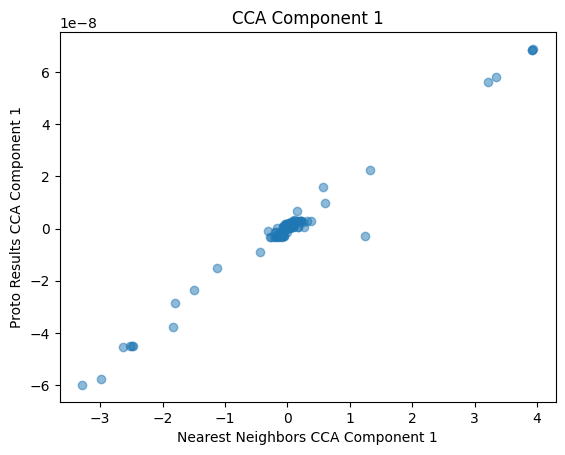

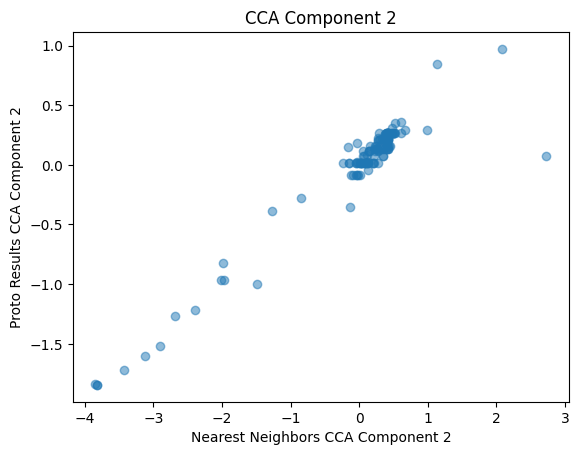

In [12]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

def pca_cca(nearest_neighbors_array, proto_results_array, pca_components=50, cca_components=10, max_iter=1000):
    # Flatten the arrays to 2D
    n_samples, k_neighbors, n_features = nearest_neighbors_array.shape
    nearest_neighbors_flat = nearest_neighbors_array.reshape(n_samples * k_neighbors, n_features)
    proto_results_flat = proto_results_array.reshape(n_samples * k_neighbors, n_features)
    
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=pca_components)
    nearest_neighbors_pca = pca.fit_transform(nearest_neighbors_flat)
    proto_results_pca = pca.fit_transform(proto_results_flat)
    
    # Apply CCA on PCA-reduced features
    n_components = min(nearest_neighbors_pca.shape[1], proto_results_pca.shape[1], cca_components)  # Set n_components to a feasible value
    cca = CCA(n_components=n_components, max_iter=max_iter)
    nearest_neighbors_c, proto_results_c = cca.fit_transform(nearest_neighbors_pca, proto_results_pca)
    
    # Compute the canonical correlations
    correlations = np.corrcoef(nearest_neighbors_c.T, proto_results_c.T).diagonal(offset=n_components)
    return correlations, nearest_neighbors_c, proto_results_c, n_components


correlations, nearest_neighbors_c, proto_results_c, n_components = pca_cca(nearest_neighbors_array, proto_results_array)
print("Canonical Correlations: ", correlations)

# Visualize the canonical variables if needed
plt.scatter(nearest_neighbors_c[:, 0], proto_results_c[:, 0], alpha=0.5)
plt.xlabel('Nearest Neighbors CCA Component 1')
plt.ylabel('Proto Results CCA Component 1')
plt.title('CCA Component 1')
plt.show()

plt.scatter(nearest_neighbors_c[:, 1], proto_results_c[:, 1], alpha=0.5)
plt.xlabel('Nearest Neighbors CCA Component 2')
plt.ylabel('Proto Results CCA Component 2')
plt.title('CCA Component 2')
plt.show()


High Canonical Correlations- Indicate strong linear relationships between linear combinations of the features from the two sets. This suggests that, when viewed through the lens of CCA, the two sets of features share a lot of common information.\
Modest Pearson Correlation -Indicates that direct, element-wise comparisons between corresponding features from the two sets show only modest correlation. This suggests more variability and less direct linear relationship at the individual feature level.

In [13]:
control_array_0 = np.random.rand(13, 10, 100352)  # Example data
control_array_1 = np.random.rand(13, 10, 100352)  # Example data

pearson_control_results = calculate_pearson_correlation(control_array_0, control_array_1)
print("Pearson Correlation Control: ", np.mean(pearson_control_results))
cca_control_results, _, _, _ = pca_cca(control_array_0, control_array_1)
print("Canonical Correlations Control: ", cca_control_results)

Pearson Correlation Control:  -0.00036345225239884857
Canonical Correlations Control:  [0.97241687 0.9540945  0.94256513 0.93574172 0.91923394 0.90988951
 0.89508186 0.88329378 0.87264242 0.86887833]


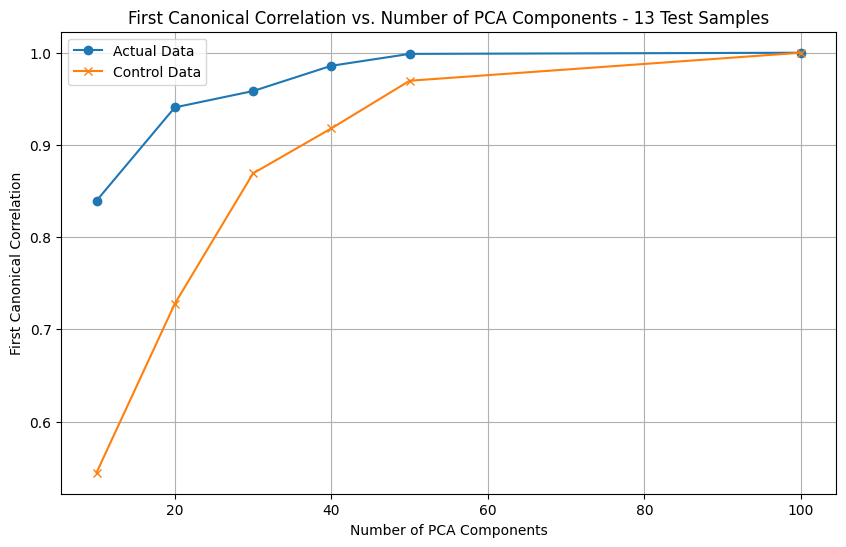

In [14]:
# Define the n_component values to iterate over
pca_component_values = [10, 20, 30, 40, 50, 100]
actual_correlations_first = []
control_correlations_first = []

for n_components in pca_component_values:
    actual_correlations,_,_,_ = pca_cca(nearest_neighbors_array, proto_results_array, n_components)
    control_correlations,_,_,_ = pca_cca(control_array_0, control_array_1, n_components)
    actual_correlations_first.append(actual_correlations[0])  # First canonical correlation
    control_correlations_first.append(control_correlations[0])  # First canonical correlation


plt.figure(figsize=(10, 6))
plt.plot(pca_component_values, actual_correlations_first, label='Actual Data', marker='o')
plt.plot(pca_component_values, control_correlations_first, label='Control Data', marker='x')
plt.xlabel('Number of PCA Components')
plt.ylabel('First Canonical Correlation')
plt.title('First Canonical Correlation vs. Number of PCA Components - 13 Test Samples')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.feature_selection import mutual_info_regression


def calculate_mutual_information(nearest_neighbors_array, proto_results_array):
    mutual_infos = []
    for i in range(nearest_neighbors_array.shape[0]):
        for j in range(nearest_neighbors_array.shape[1]):
            mi = mutual_info_regression(nearest_neighbors_array[i, j, :].reshape(-1, 1), proto_results_array[i, j, :])
            mutual_infos.append(mi[0])
    return np.mean(mutual_infos)

# Calculate mutual information
mi_score = calculate_mutual_information(nearest_neighbors_array, proto_results_array)
print("Mutual Information Score: ", mi_score)


Mutual Information Score:  0.10681672105857058


In [16]:
control_mi_score = calculate_mutual_information(control_array_0, control_array_1)
print("Control MI score: ", control_mi_score)

Control MI score:  0.001021178445118036


In [17]:
from scipy.stats import spearmanr
import numpy as np

def calculate_spearman_correlation(nearest_neighbors_array, proto_results_array):
    n_samples, k_neighbors, n_features = nearest_neighbors_array.shape
    correlations = []

    for i in range(n_samples):
        sample_correlations = []
        for j in range(k_neighbors):
            for k in range(k_neighbors):
                correlation, _ = spearmanr(nearest_neighbors_array[i, j, :], proto_results_array[i, k, :])
                sample_correlations.append(correlation)
        correlations.append(np.mean(sample_correlations))
    
    overall_correlation = np.mean(correlations)
    return overall_correlation, correlations

# Example usage:
# nearest_neighbors_array and proto_results_array should be your actual data arrays
spearman_correlation, sample_correlations = calculate_spearman_correlation(nearest_neighbors_array, proto_results_array)
print("Overall Spearman Correlation: ", spearman_correlation)
print("Sample-wise Correlations: ", sample_correlations)

# For control data:
control_array_0 = np.random.rand(13, 10, 100352)
control_array_1 = np.random.rand(13, 10, 100352)
spearman_control_correlation, control_sample_correlations = calculate_spearman_correlation(control_array_0, control_array_1)
print("Overall Spearman Correlation Control: ", spearman_control_correlation)
print("Control Sample-wise Correlations: ", control_sample_correlations)


Overall Spearman Correlation:  0.3324536200165651
Sample-wise Correlations:  [0.33652331445869166, 0.3356743160491391, 0.2730145145647136, 0.29693938249565516, 0.21858204424053404, 0.22822721890255757, 0.3131820378180197, 0.3191801628342638, 0.3651843898923584, 0.365383670790198, 0.40405455236211607, 0.3356743160491391, 0.5302771397579595]
Overall Spearman Correlation Control:  -2.0776918684195953e-06
Control Sample-wise Correlations:  [-7.057768603670199e-05, -2.955428150157406e-05, -1.1001261928223257e-05, -0.00019928166776040778, 0.00010841445961133201, 0.00012717999595143522, 0.0001813309295246047, -0.0002542636672391344, -0.0008352511928520623, 0.0001689777875845343, 0.000335171108781996, -0.0002939413543613511, 0.0007457868359360979]
